In [2]:
import os
import pandas as pd
from datetime import datetime
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import contextily as ctx

import rasterio as rio
import rioxarray as rxr

import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.rcParams['figure.dpi'] = 300
# plt.style.use('ggplot')

## 1. Import Data

In [3]:
# cmap = ["#EE2617FF", "#F2A241FF", "#558934FF", "#0E54B6FF"] # CarolMan
cmap = ["#98BDDCFF", "#F6955EFF", "#682C37FF", "#A89F8EFF", "#9B6981FF", "#7887A4FF"] # Arches

In [4]:
fielddata = pd.read_csv('../../data/field_data/LWC_LFM_WP_dates20230525.csv')

fielddata['mpa_mean'] = fielddata['mpa_mean'] * -1   # data was collected as positive values

def parse_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d')
    except:
        return None
    
fielddata['date'] = fielddata.apply(lambda row: parse_date(row['date_wp']), axis=1)

def check_date_md(date):
    # check if date is within 8 days of any of the image dates
    for img_date in img_date_list:
        if abs((date - img_date).days) <= 8:
            return True
    return False

lwc = fielddata[['tree','time','species','date','lwc_mean']] \
        .dropna().drop_duplicates().reset_index(drop=True)
lwc = lwc[lwc['time'] == 'md']
lwc = lwc[lwc['lwc_mean'] < 1.4]   # indra says these very high values are most likely erroneous
lwc = lwc.drop_duplicates()

In [5]:
lai_data = pd.read_csv('../../data/field_data/LAI_final.csv')

In [6]:
cwc_data_dir = 'C:/Users/jeanallen/Desktop/SHIFT_CWC/data/SHIFT_data/cwc_1100_1300'

# full_date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']
date_list = ['20220429', '20220503', '20220511', '20220914'] # no field data on 5/17, georeferencing failed on 5/29, so this is what we've got
datetime_list = [datetime.strptime(date, '%Y%m%d') for date in date_list]

# handling for non-convergence in the invert_liquid_water function
def kill_nans(df):
    mask = (df['CWC'] > 0.4998) & (df['CWC'] < 0.5) # dumb floating point bullsh*t
    df.loc[mask, 'CWC'] = np.nan
    return df

cwc_file_paths = [os.path.join(cwc_data_dir, date + '_cwc.csv') for date in date_list]
# read in one file just to get the tree numbers, then sync up the rest of the data into one big dataframe
cwc = kill_nans(pd.read_csv(cwc_file_paths[0]).set_index('Tree Number').drop(columns=['MAE', 'Intercept', 'Slope'])).rename(columns={'CWC': 'CWC_' + date_list[0]})
for date, file_path in zip(date_list[1:], cwc_file_paths[1:]):
    other_df = pd.read_csv(file_path).set_index('Tree Number')
    other_df = kill_nans(other_df)
    cwc = cwc.join(other_df['CWC']).rename(columns={'CWC': 'CWC_' + date})

# now make a list of dataframes containing all the good stuff
cwc_df_list = []
for date, file_path in zip(date_list, cwc_file_paths):
    cwc_df = pd.read_csv(file_path)
    cwc_df['datetime'] = datetime.strptime(date, '%Y%m%d')
    cwc_df = kill_nans(cwc_df)
    cwc_df_list.append(cwc_df)

# # check for fielddata collected within 4 days of 5/17/2022
# this_date = datetime(2022, 5, 17)
# fielddata[(fielddata['date'] >= this_date - pd.Timedelta(days=8)) & (fielddata['date'] <= this_date + pd.Timedelta(days=8)) & (fielddata['time'] == 'pd')]

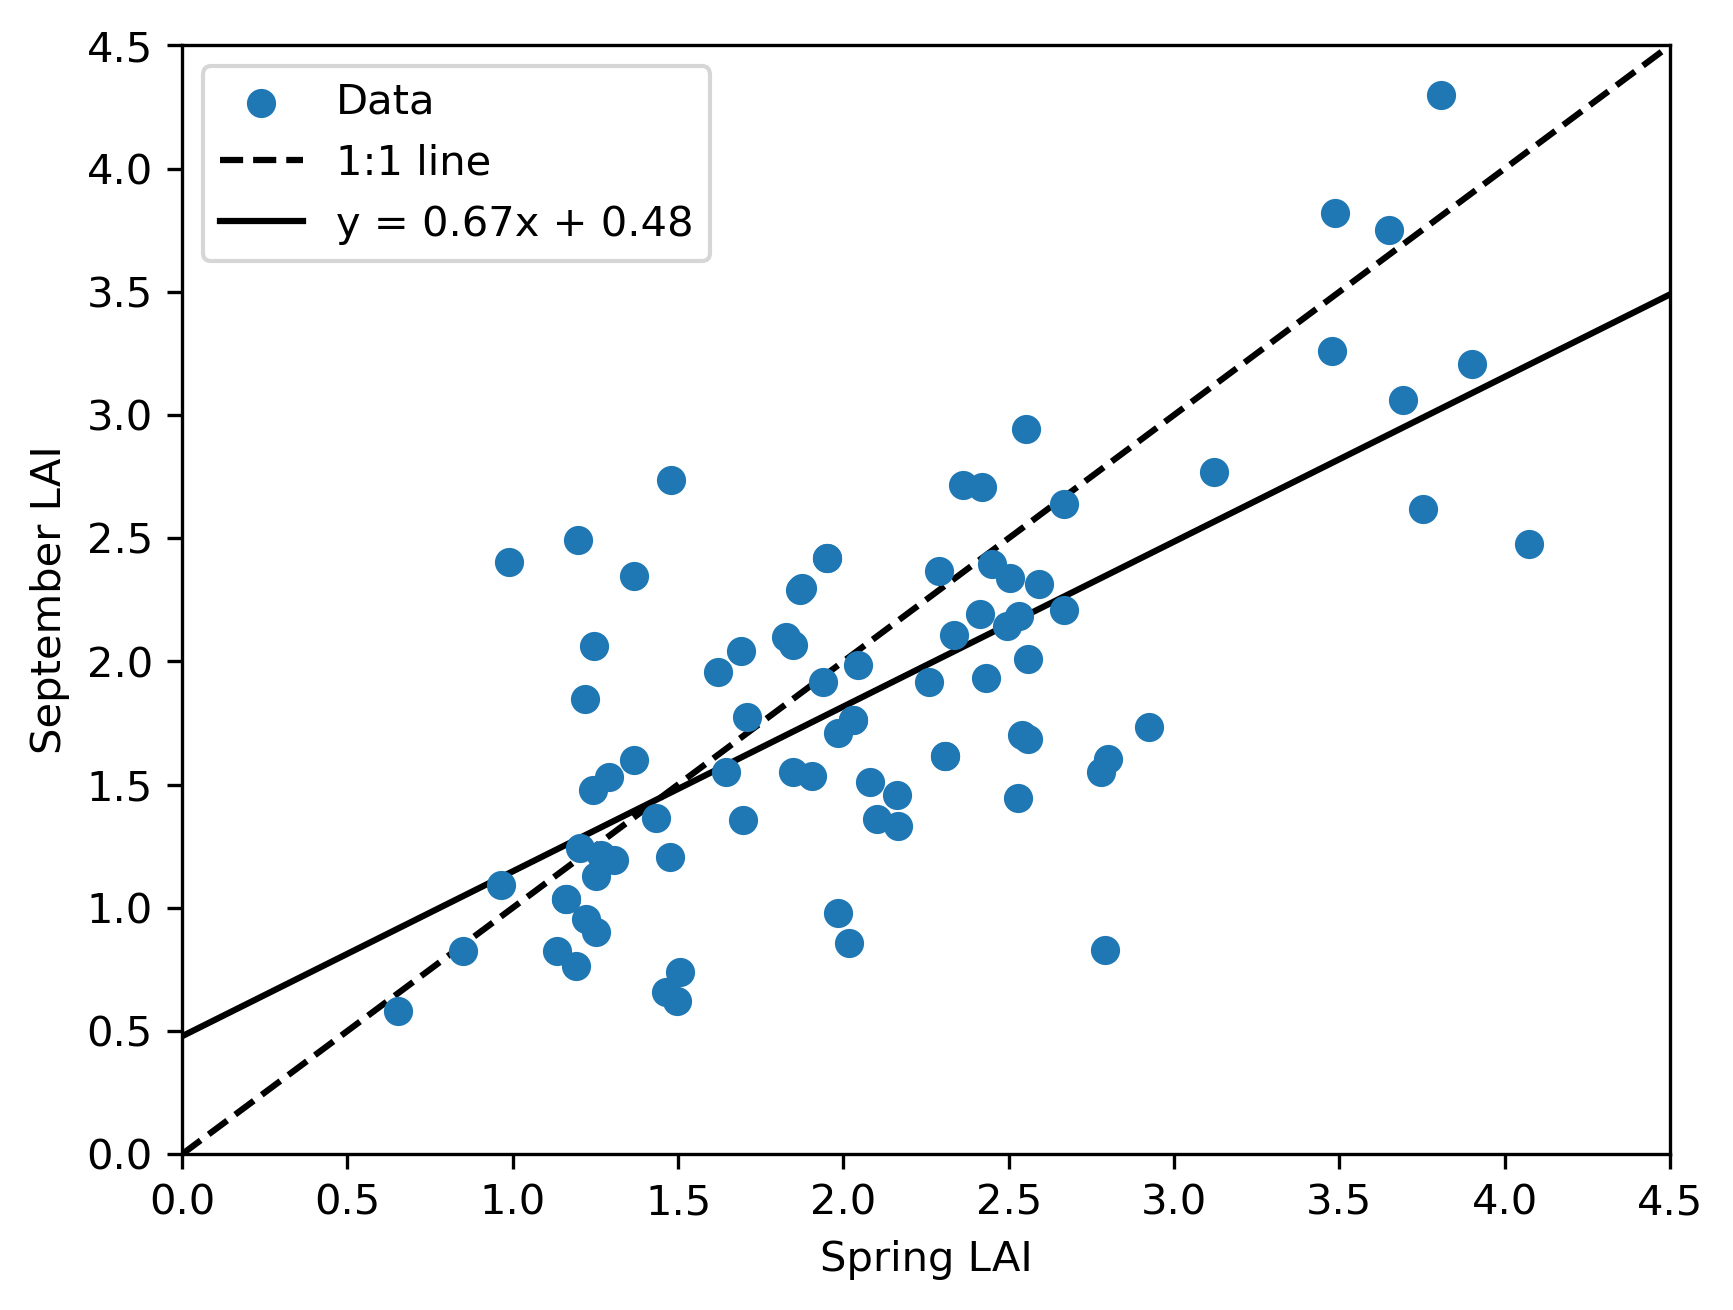

In [7]:
# join LAI data onto the CWC data
def get_LAI_CWC(treenum, lai_type='springlai'):
    # some trees are too close together to be resolved by the LAI data
    # first check if this tree was "on its own" in the LAI data...
    treenum = int(treenum)
    lai = lai_data[lai_data['Treestr'] == treenum][lai_type]
    if len(lai) == 1:
        return lai.values[0]
    else:
        # if not, check if there are any Treestr entries where the first four digits match treenum
        lai = lai_data[lai_data['Treestr'].apply(lambda x: str(x)[:4]) == str(treenum)[:4]][lai_type]
        if len(lai) == 1:
            return lai.values[0]
        else:
            # finally, check if there are any Treestr entries where the last four digits match treenum
            lai = lai_data[lai_data['Treestr'].apply(lambda x: str(x)[-4:]) == str(treenum)[-4:]][lai_type]
            if len(lai) == 1:
                return lai.values[0]
            else:
                return np.nan
        
cwc['springlai'] = cwc.index.map(get_LAI_CWC)
cwc['septlai'] = cwc.index.map(lambda x: get_LAI_CWC(x, 'septlai'))
plt.scatter(cwc['springlai'], cwc['septlai'], zorder=2, label='Data')
plt.xlabel('Spring LAI')
plt.ylabel('September LAI')
plt.plot([0, 6], [0, 6], color='black', zorder=1, linestyle='--', label='1:1 line')
# regression
cwc_regress = cwc[['springlai', 'septlai']].dropna()
cwc_regress = sm.add_constant(cwc_regress)
model = sm.OLS(cwc_regress['septlai'], cwc_regress[['const', 'springlai']]).fit()
plt.plot([0,6], model.predict([[1, 0], [1, 6]]), color='black', zorder=1, label='y = {:.2f}x + {:.2f}'.format(model.params['springlai'], model.params['const']))
plt.xlim(0, 4.5)
plt.ylim(0, 4.5)
plt.legend()
plt.show()

In [8]:
# align CWC data with the field data
def get_cwc_data_md(tree_id, date):
    # check if there is a cwc date within 4 days of the field data date
    for this_date in datetime_list:
        if abs((this_date - date).days) <= 4:
            try:
                return cwc.loc[tree_id, 'CWC_' + this_date.strftime('%Y%m%d')]
            except:
                return None
    return None

lwc['cwc_md'] = lwc.apply(lambda row: get_cwc_data_md(row['tree'], row['date']), axis=1)

## 2. Separate Scatterplots for Each Date

In [9]:
i = 0
date = date_list[i]
date

'20220429'

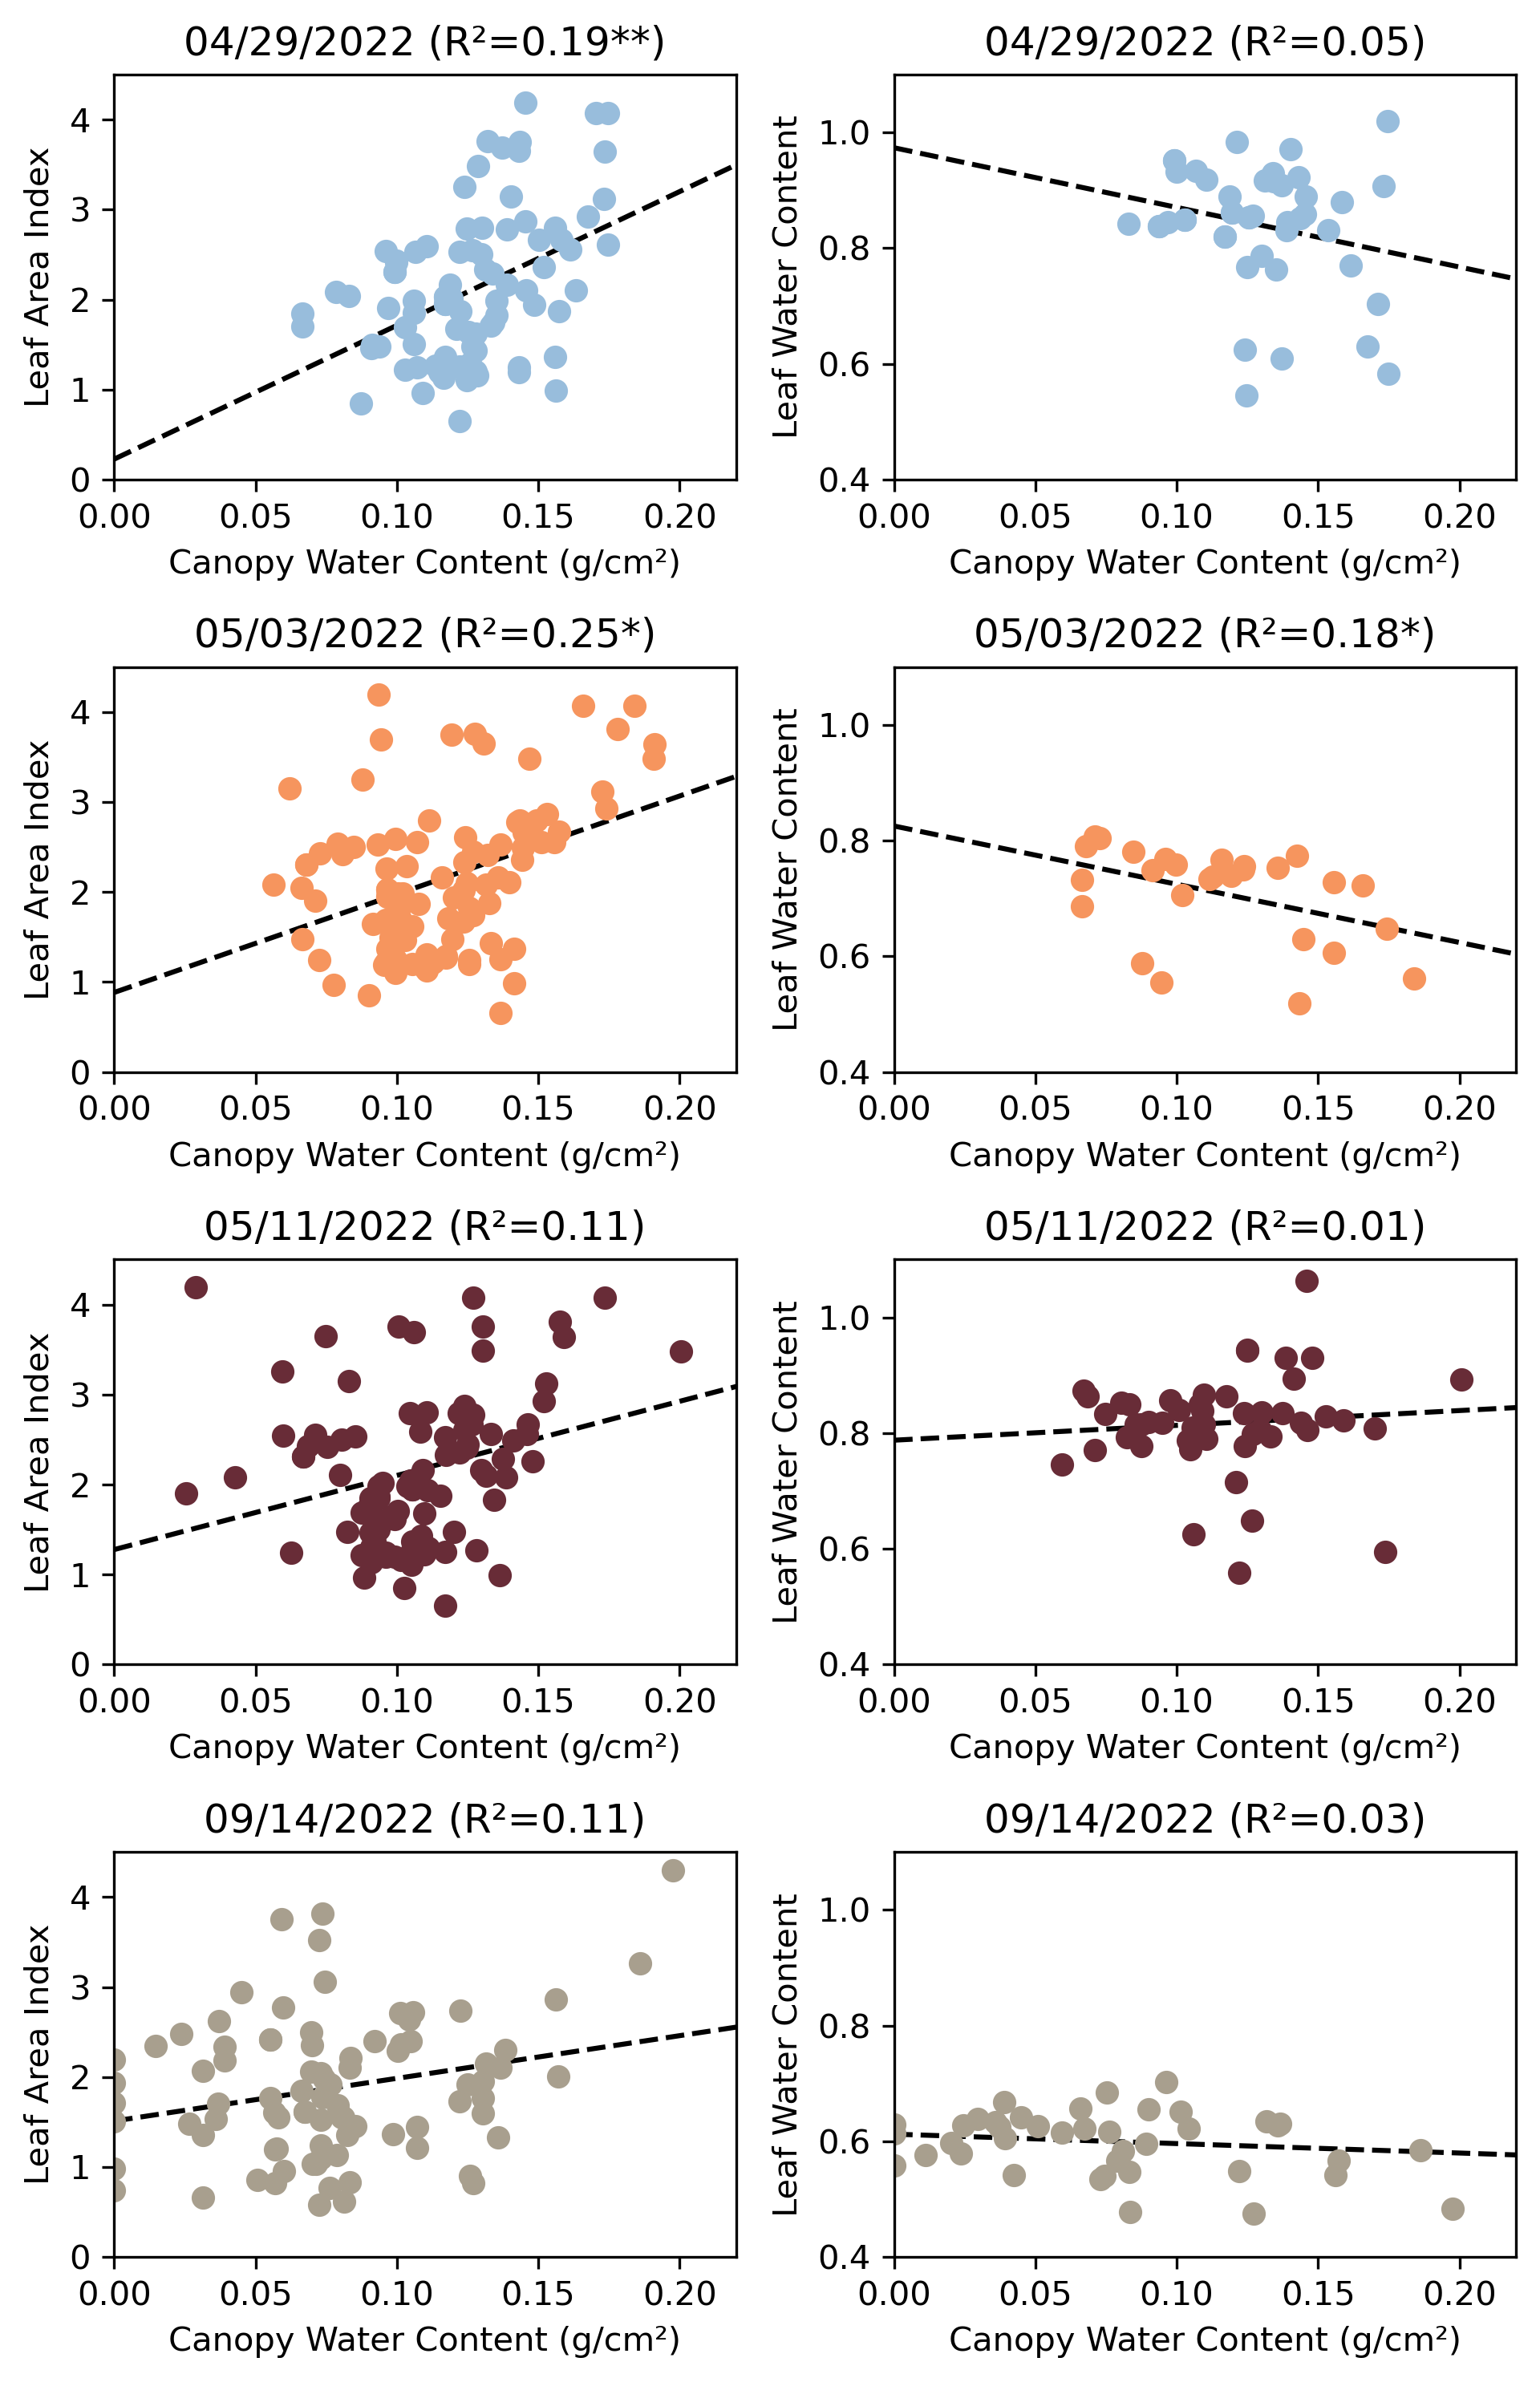

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(6.5, 10))

def pretty_date(date):
    return date.strftime('%m/%d/%Y')


# on left side -- CWC vs. LAI
for i, date in enumerate(date_list[0:3]):
    ax = axs[i, 0]
    ax.scatter(cwc['CWC_' + date], cwc['springlai'], zorder=2, label='Data', color=cmap[i])
    ax.set_xlabel('Canopy Water Content (g/cm²)')
    ax.set_ylabel('Leaf Area Index')
    # regression
    cwc_regress = cwc[['CWC_' + date, 'springlai']].dropna()
    cwc_regress = sm.add_constant(cwc_regress)
    model = sm.OLS(cwc_regress['springlai'], cwc_regress[['const', 'CWC_' + date]]).fit()
    # for calculating R2, downsample the LAI data to the same sample size as the LWC data, then average all those R2 values together
    lwc_num = len(lwc[(lwc['date'] <= datetime_list[i] + pd.Timedelta(days=4)) & (lwc['date'] >= datetime_list[i] - pd.Timedelta(days=4))])
    r2s = []
    p_vals = []
    for j in range (20):
        random_sample = cwc_regress.sample(lwc_num, replace=False)
        mini_model = sm.OLS(random_sample['springlai'], random_sample[['const', 'CWC_' + date]]).fit()
        r2s.append(mini_model.rsquared)
        p_vals.append(mini_model.f_pvalue)
    r2s = np.array(r2s)
    r2s = np.nanmean(r2s)
    r2str = str(r2s)[0:4]
    pval = np.nanmean(p_vals)
    if pval < 0.05:
        r2str = r2str + '*'
    if pval < 0.01:
        r2str = r2str + '*'
    ax.plot([0,1], model.predict([[1, 0], [1, 1]]), color='black', zorder=1, label='Lin. Reg.', linestyle='--')
    # ax.legend(loc='lower right')
    ax.set_xlim(0.0, 0.22)
    ax.set_ylim(0, 4.5)
    ax.set_title(pretty_date(datetime_list[i]) + ' (R²=' + r2str + ')')
    # ax.grid(True)
# do september separately
ax = axs[3, 0]
ax.scatter(cwc['CWC_' + date_list[3]], cwc['septlai'], zorder=2, label='Data', color=cmap[3])
ax.set_xlabel('Canopy Water Content (g/cm²)')
ax.set_ylabel('Leaf Area Index')
# regression
cwc_regress = cwc[['CWC_' + date_list[3], 'septlai']].dropna()
cwc_regress = sm.add_constant(cwc_regress)
model = sm.OLS(cwc_regress['septlai'], cwc_regress[['const', 'CWC_' + date_list[3]]]).fit()
# for calculating R2, downsample the LAI data to the same sample size as the LWC data, then average all those R2 values together
lwc_num = len(lwc[(lwc['date'] <= datetime_list[3] + pd.Timedelta(days=4)) & (lwc['date'] >= datetime_list[3] - pd.Timedelta(days=4))])
r2s = []
p_vals = []
for j in range (20):
    random_sample = cwc_regress.sample(lwc_num, replace=False)
    mini_model = sm.OLS(random_sample['septlai'], random_sample[['const', 'CWC_' + date_list[3]]]).fit()
    r2s.append(mini_model.rsquared)
    p_vals.append(mini_model.f_pvalue)
r2s = np.array(r2s)
r2s = np.nanmean(r2s)
r2str = str(r2s)[0:4]
pval = np.nanmean(p_vals)
if pval < 0.05:
    r2str = r2str + '*'
if pval < 0.01:
    r2str = r2str + '*'
ax.plot([0,1], model.predict([[1, 0], [1, 1]]), color='black', zorder=1, label='Lin. Reg.', linestyle='--')
# ax.legend('lower right')    
ax.set_xlim(0.0, 0.22)
ax.set_ylim(0, 4.5)
ax.set_title(pretty_date(datetime_list[3]) + ' (R²=' + r2str + ')')
# ax.grid(True)

# on right side -- CWC vs. LWC
for i, date in enumerate(date_list):
    ax = axs[i, 1]
    lwc_filtered = lwc[(lwc['date'] <= datetime_list[i] + pd.Timedelta(days=4)) & (lwc['date'] >= datetime_list[i] - pd.Timedelta(days=4))]
    lwc_filtered = lwc_filtered[['cwc_md', 'lwc_mean']].dropna()
    ax.scatter(lwc_filtered['cwc_md'], lwc_filtered['lwc_mean'], zorder=2, label='Data', color=cmap[i])
    ax.set_xlabel('Canopy Water Content (g/cm²)')
    ax.set_ylabel('Leaf Water Content')
    # regression
    lwc_regress = lwc_filtered.dropna()
    lwc_regress = sm.add_constant(lwc_regress)
    model = sm.OLS(lwc_regress['lwc_mean'], lwc_regress[['const', 'cwc_md']]).fit()
    r2str = str(model.rsquared)[0:4]
    pval = model.f_pvalue
    if pval < 0.05:
        r2str = r2str + '*'
    if pval < 0.01:
        r2str = r2str + '*'
    ax.plot([0,1], model.predict([[1, 0], [1, 1]]), color='black', zorder=1, label='Lin. Reg.', linestyle='--')
    # ax.legend(loc='lower right')
    ax.set_xlim(0.0, 0.22)
    ax.set_ylim(0.4, 1.1)
    ax.set_title(pretty_date(datetime_list[i]) + ' (R²=' + r2str + ')')
    # ax.grid(True)


plt.tight_layout()
plt.savefig('lai_vs_lwc_cwc.png')
plt.show()

In [11]:
lwc_just_good_dates = pd.DataFrame()

for i, date in enumerate(date_list):
    lwc_filtered = lwc[(lwc['date'] <= datetime_list[i] + pd.Timedelta(days=4)) & (lwc['date'] >= datetime_list[i] - pd.Timedelta(days=4))]
    lwc_filtered = lwc_filtered[['cwc_md', 'lwc_mean', 'tree', 'species']].dropna()
    lwc_filtered['date'] = datetime_list[i]
    lwc_just_good_dates = lwc_just_good_dates.append(lwc_filtered)

tree_list = lwc_just_good_dates.dropna().tree.unique()
species_list = []
for tree in tree_list:
    species_list.append(lwc_just_good_dates[lwc_just_good_dates['tree'] == tree].species.unique()[0])

# get number of trees per species
species_counts = lwc_just_good_dates.groupby('species').tree.nunique()
species_counts

C:\Users\jeanallen\AppData\Local\Temp\ipykernel_35676\1146837012.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lwc_just_good_dates = lwc_just_good_dates.append(lwc_filtered)
C:\Users\jeanallen\AppData\Local\Temp\ipykernel_35676\1146837012.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lwc_just_good_dates = lwc_just_good_dates.append(lwc_filtered)
C:\Users\jeanallen\AppData\Local\Temp\ipykernel_35676\1146837012.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lwc_just_good_dates = lwc_just_good_dates.append(lwc_filtered)
C:\Users\jeanallen\AppData\Local\Temp\ipykernel_35676\1146837012.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

species
blue oak    42
live oak    14
Name: tree, dtype: int64